ЭКСПЕРИМЕНТАЛЬНОЕ ИССЛЕДОВАНИЕ МЕТОДА ВЫЯВЛЕНИЯ И ОЦЕНКИ НИЗКО-СВЯЗАННЫХ КВАРТАЛОВ, ИМЕЮЩИХ ХАРАКТЕРИСТИКИ ЦЕНТРАЛЬНЫХ МЕСТ И ПОДВЕРЖЕННЫХ ВЛИЯНИЮ МАЯТНИКОВОЙ ТРУДОВОЙ МИГРАЦИИ

In [ ]:
import pickle
%load_ext autoreload
%autoreload 2
import numpy as np

from blocksnet import City, Accessibility

city = City.from_pickle('model.pickle')

Получаем кварталы с дорогами из готовой модели

In [2]:
blocks_old = city.get_blocks_gdf()
blocks_old = blocks_old[['geometry', 'land_use', 'population', 'site_area']]

In [ ]:
import geopandas as gpd

blocks = gpd.read_file('blocks.geojson')
blocks['site_area'] = blocks.geometry.area


Получаем кварталы без дорог

In [4]:
import pandas as pd

blocks = pd.merge(blocks, blocks_old[['population']], left_on='id', right_index=True, how='inner')

Обьединяем, чтобы сохранить население 

In [5]:
blocks.set_index('id', inplace=True)

Скачиваем граф и считаем матрицу по расстоянию (так как в модели по времени)

In [6]:
matrix = city.accessibility_matrix
matrix = matrix.loc[blocks.index, blocks.index]

In [7]:
from blocksnet import Connectivity

connectivity = Connectivity(city_model=city)
result = connectivity.calculate()

In [8]:
result

geometry  connectivity
id                                                                   
0     POLYGON ((439443.697 6133295.380, 439441.963 6...      9.093750
1     POLYGON ((439217.809 6133376.404, 439247.182 6...      9.085938
2     POLYGON ((439217.809 6133376.404, 439184.460 6...      9.171875
3     POLYGON ((439184.460 6133392.267, 439217.809 6...      9.242188
4     POLYGON ((439184.460 6133392.267, 438928.486 6...      9.195312
...                                                 ...           ...
1820  POLYGON ((433557.411 6141740.178, 433598.918 6...     19.468750
1821  POLYGON ((434034.096 6140367.703, 434019.346 6...     17.703125
1822  POLYGON ((442122.399 6135412.372, 442052.999 6...      8.085938
1823  POLYGON ((436648.560 6137848.494, 436596.305 6...     13.070312
1824  POLYGON ((436149.139 6137961.868, 436088.565 6...     13.656250

[1825 rows x 2 columns]

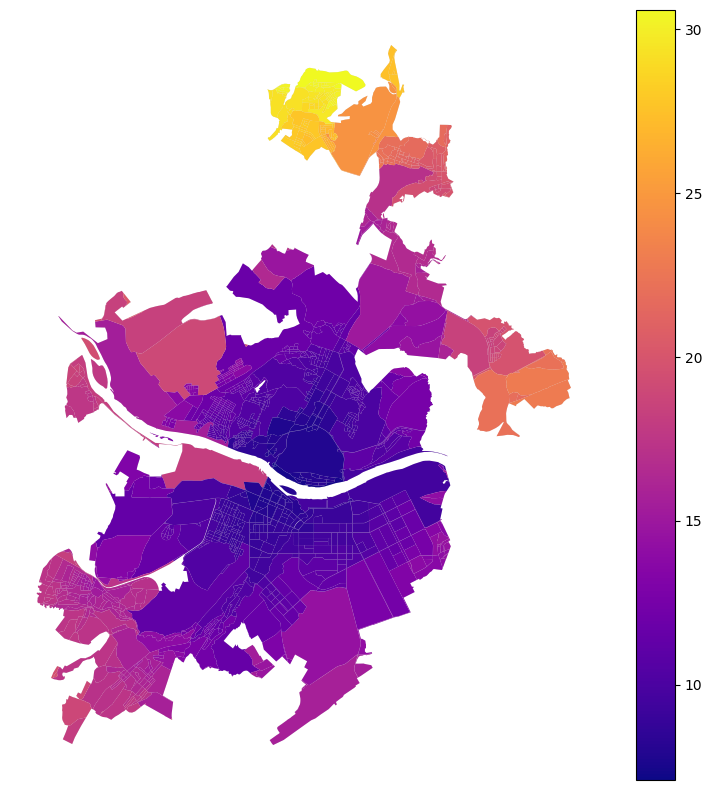

In [9]:
import matplotlib.pyplot as plt

PLOT_KWARGS = {"column": 'connectivity', "cmap": "plasma", "legend": True}
ax = result.plot(color="#ddd", linewidth=0.1, figsize=(10, 10))
result.plot(ax=ax, linewidth=0.1, **PLOT_KWARGS)
ax.axis('off')
plt.savefig('Связанность.png', dpi=900, bbox_inches='tight')

In [10]:
from blocksnet import AccessibilityProcessor
ap = AccessibilityProcessor(blocks)

In [ ]:
ap = AccessibilityProcessor(blocks)
graph = ap.get_intermodal_graph()

In [12]:
for u, v, data in graph.edges(data=True):
    data['length_km'] = data['length_meter'] / 1000 # Перевод из м в км

In [13]:
acc_mx = ap.get_accessibility_matrix(graph, weight='time_min')

In [14]:
matrix = acc_mx.copy()

Отфильтруем лишние колонки

In [ ]:
print(blocks.columns)

Index(['land_use', 'geometry', 'site_area', 'population'], dtype='object')


In [ ]:
blocks = blocks[['land_use', 'population', 'site_area', 'geometry']]

In [16]:
def min_max_normalization(data, new_min=0, new_max=1):
    min_value = np.min(data)
    max_value = np.max(data)
    normalized_data = (data - min_value) / (max_value - min_value) * (new_max - new_min) + new_min
    return normalized_data


# 
q1_landuse = {
    'industrial': 0.25,
    'business': 0.3,
    'special': 0.1,
    'transport': 0.1,
    'residential': 0.1,
    'none': 0.06,
    'agriculture': 0.05,
    'recreation': 0.05
}

blocks['q1'] = blocks['land_use'].apply(lambda x: q1_landuse.get(x, 0))
blocks['q2'] = min_max_normalization(np.sqrt(blocks['site_area']))
blocks['q3'] = blocks['q1'] * blocks['q2']
q3 = blocks['q3'].sum()
blocks['mark'] = blocks['q3'] / q3

In [ ]:
c = blocks['population'].sum()
rng = np.random.default_rng(seed=0)
r = pd.Series(0, blocks.index)

blocks['mark'] = pd.to_numeric(blocks['mark'], errors='coerce')
blocks['mark'] = blocks['mark'].fillna(0)

p = blocks['mark'].values
p_sum = p.sum()

if p_sum == 0:
    p = np.ones_like(p) / len(p)
else:
    p = p / p_sum 

choice = np.unique(rng.choice(blocks.index, int(c), p=p), return_counts=True)
choice = r.add(pd.Series(choice[1], choice[0]), fill_value=0)


In [18]:
blocks['jobs'] = np.multiply(choice, 0.8).astype(int)

In [19]:
blocks['workers'] = blocks['population']

In [ ]:
blocks['jobs'].sum()

In [ ]:
blocks['population'].sum()

In [22]:
destination_matrix = pd.DataFrame(
    0,
    index=matrix.columns,
    columns=matrix.index,
)
blocks['jobs_left'] = blocks['jobs']
blocks['workers_left'] = blocks['workers']

In [ ]:
from pandarallel import pandarallel

pandarallel.initialize(progress_bar=False, verbose=0)


def workflows_loop_gravity(
        blocks: gpd.GeoDataFrame,
        distance_matrix: pd.DataFrame,
        selection_range,
        destination_matrix: pd.DataFrame,
):
    def calculate_visit_prob(x):
        import numpy as np
        k = 0.2

        if 0 <= x < 30:
            y = (np.exp(k * x) - 1) / (np.exp(30 * k) - 1) * 0.27 + 0.08
        elif 30 <= x <= 50:
            y = 0.60 * np.exp(-((x - 40) ** 2) / (2 * 9.63 ** 2))
        elif x > 50:
            y = 0.35 * np.exp(-k * (x - 50))
        else:
            y = None  # Для значений x вне указанных диапазонов

        return y

    def apply_function_based_on_size(df, func, axis, threshold=500):
        if len(df) > threshold:
            return df.parallel_apply(func, axis=axis)
        else:
            return df.apply(func, axis=axis)

    def calculate_flows_workers(loc):
        import numpy as np
        import pandas as pd

        c = blocks.loc[loc.name]["jobs_left"]
        p = loc.apply(calculate_visit_prob)
        # threshold = p.quantile(best_choice)
        thres = p[p >= 0.15]
        if len(thres) > 0:
            p = thres
        p = p / p.sum()
        if p.sum() == 0:
            return loc
        rng = np.random.default_rng(seed=0)
        r = pd.Series(0, p.index)
        choice = np.unique(rng.choice(p.index, int(c), p=p.values), return_counts=True)
        choice = r.add(pd.Series(choice[1], choice[0]), fill_value=0)

        return choice

    def balance_flows_to_jobs(loc):
        import numpy as np
        import pandas as pd

        d = blocks.loc[loc.name]["workers_left"]
        loc = loc[loc > 0]
        if loc.sum() > 0:
            p = loc / loc.sum()
            rng = np.random.default_rng(seed=0)
            r = pd.Series(0, p.index)
            choice = np.unique(rng.choice(p.index, int(d), p=p.values), return_counts=True)
            choice = r.add(pd.Series(choice[1], choice[0]), fill_value=0)
            choice = pd.Series(
                data=np.minimum(loc.sort_index().values, choice.sort_index().values),
                index=loc.sort_index().index,
            )
            return choice
        return loc

    temp_destination_matrix = apply_function_based_on_size(
        distance_matrix, lambda x: calculate_flows_workers(x[x <= selection_range]), 1
    )

    temp_destination_matrix = temp_destination_matrix.fillna(0)

    temp_destination_matrix = apply_function_based_on_size(temp_destination_matrix, balance_flows_to_jobs, 0)

    temp_destination_matrix = temp_destination_matrix.fillna(0)
    destination_matrix = destination_matrix.add(temp_destination_matrix, fill_value=0)

    axis_1 = destination_matrix.sum(axis=1)
    axis_0 = destination_matrix.sum(axis=0)

    blocks["jobs_left"] = blocks["jobs"].subtract(axis_1, fill_value=0)
    blocks["workers_left"] = blocks["workers"].subtract(axis_0, fill_value=0)

    distance_matrix = distance_matrix.drop(
        index=blocks[blocks["jobs_left"] == 0].index.values,
        columns=blocks[blocks["workers_left"] == 0].index.values,
        errors="ignore",
    )

    selection_range = selection_range * 1.25
    print(selection_range)

    print(len(distance_matrix.columns), len(distance_matrix.index))

    if len(distance_matrix.columns) > 0 and len(distance_matrix.index) > 0:
        return workflows_loop_gravity(
            blocks, distance_matrix, selection_range, destination_matrix
        )
    return destination_matrix


res = workflows_loop_gravity(blocks, matrix.copy(), 60, destination_matrix)

In [24]:
def additional_options(
        blocks,
        matrix,
        destination_matrix,
):
    blocks["avg_dist"] = 0
    for i in range(len(destination_matrix)):
        loc = destination_matrix.iloc[i]
        distances_all = matrix.loc[loc.name]
        blocks["avg_dist"] = (
            blocks["avg_dist"]
            .add(distances_all.multiply(loc, fill_value=0), fill_value=0)

        )

    blocks["avg_dist"] = (blocks["avg_dist"] / (blocks["workers"] - blocks["workers_left"]))

    blocks["avg_dist"] = blocks.apply(
        lambda x: np.nan if (x["workers"] == x["workers_left"]) else round(x["avg_dist"], 2), axis=1
    )


additional_options(blocks, matrix, res)

In [25]:
blocks['jobs_applyed'] = blocks['jobs'] - blocks['jobs_left']
blocks['load%'] = blocks['jobs_applyed'] / blocks['jobs'] * 100

blocks['workers_non_applyed_%'] = (blocks['workers_left'] / blocks['workers']) * 100


Визуализация

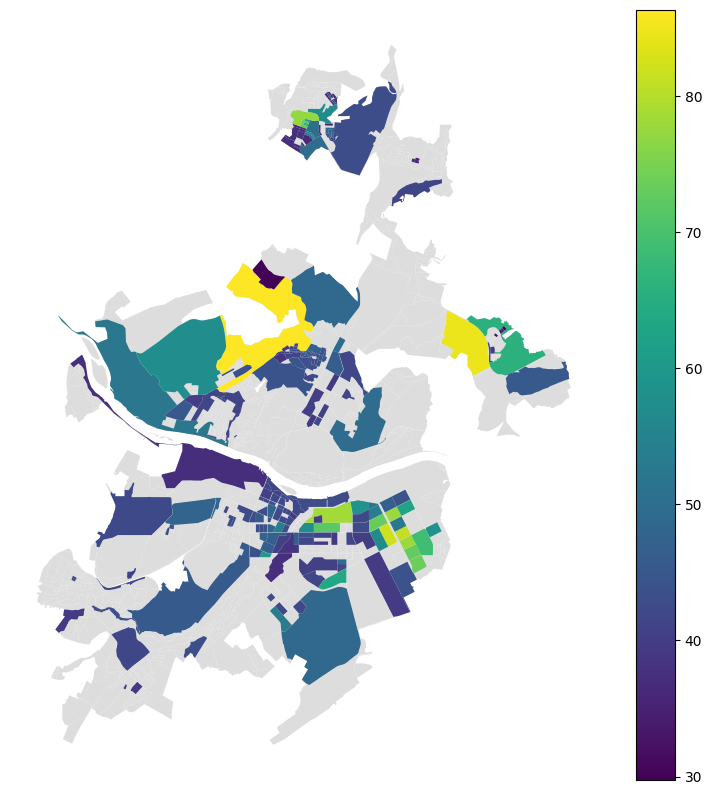

In [26]:
import matplotlib.pyplot as plt

PLOT_KWARGS = {"column": 'avg_dist', "legend": True}
ax = blocks.plot(color="#ddd", linewidth=0.1, figsize=(10, 10))
blocks.plot(ax=ax, linewidth=0.1, **PLOT_KWARGS)
ax.axis('off')
plt.savefig('20% среднее время.png', dpi=900, bbox_inches='tight')

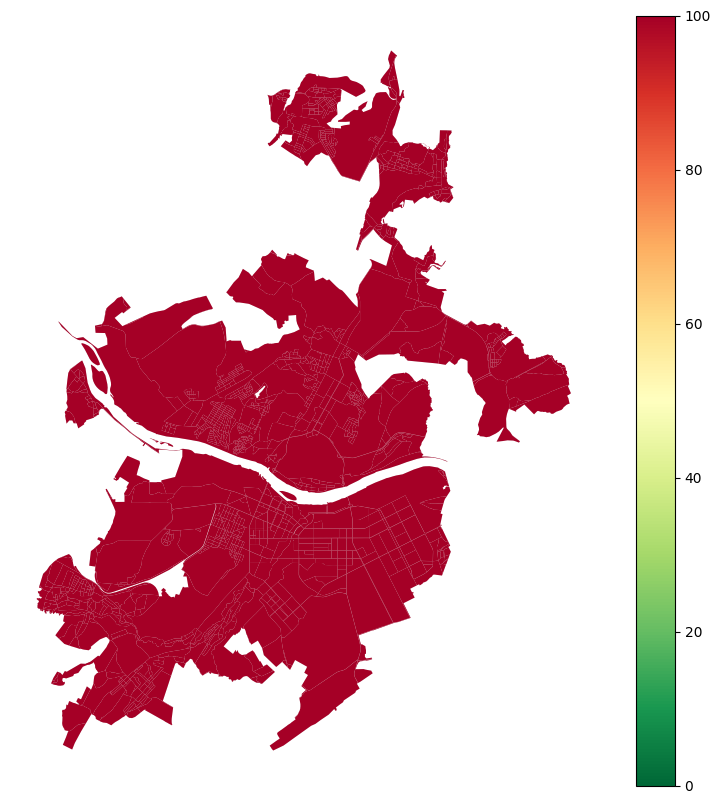

In [27]:
import matplotlib.pyplot as plt

PLOT_KWARGS = {"column": 'load%', "cmap": "RdYlGn_r", "vmin": 0, "vmax": 100, "legend": True}
ax = blocks.plot(color="#ddd", linewidth=0.1, figsize=(10, 10))
blocks.plot(ax=ax, linewidth=0.1, **PLOT_KWARGS)
ax.axis('off')
plt.savefig('20% профицит нагрузка время.png', dpi=900, bbox_inches='tight')

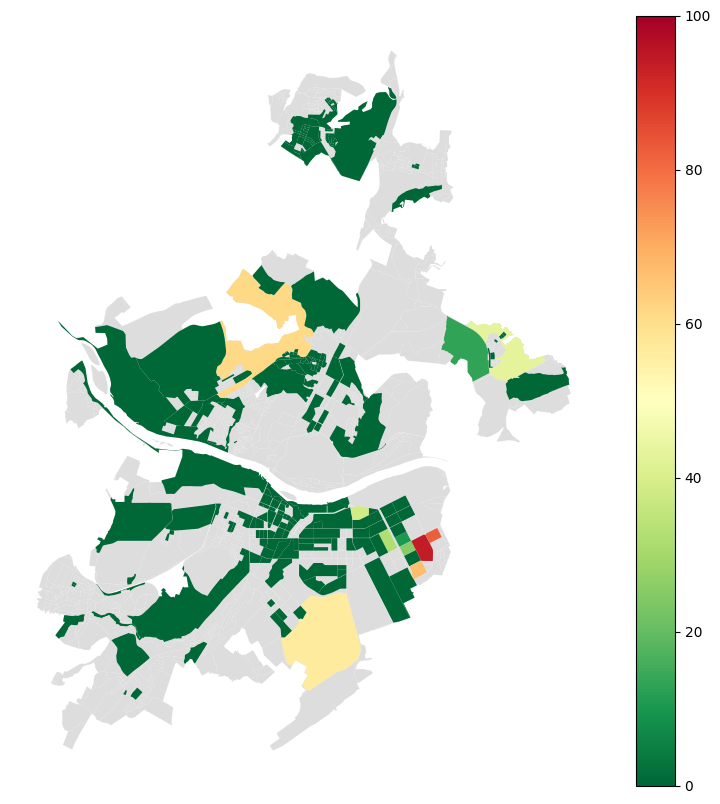

In [28]:
import matplotlib.pyplot as plt

PLOT_KWARGS = {"column": 'workers_non_applyed_%', "cmap": "RdYlGn_r", "vmin": 0, "vmax": 100, "legend": True}
ax = blocks.plot(color="#ddd", linewidth=0.1, figsize=(10, 10))
blocks.plot(ax=ax, linewidth=0.1, **PLOT_KWARGS)
ax.axis('off')
plt.savefig('20% дефицит нехватка мест время.png', dpi=900, bbox_inches='tight')

In [29]:
m1 = blocks.reset_index().explore(column='workers_non_applyed_%', tiles='CartoDB positron')

In [30]:
city = City(blocks = blocks,acc_mx=matrix)

In [31]:
from blocksnet import PopulationCentrality

centrality = PopulationCentrality(city_model=city)
result = centrality.calculate()

In [32]:
result.head()

geometry  population_centrality
id                                                                          
0   POLYGON ((439443.697 6133295.380, 439441.963 6...                   6.35
1   POLYGON ((439217.809 6133376.404, 439247.182 6...                   5.96
2   POLYGON ((439217.809 6133376.404, 439184.460 6...                   6.06
3   POLYGON ((439184.460 6133392.267, 439217.809 6...                   5.77
4   POLYGON ((439184.460 6133392.267, 438928.486 6...                   5.58

In [33]:
result.explore(column='population_centrality',cmap='plasma')

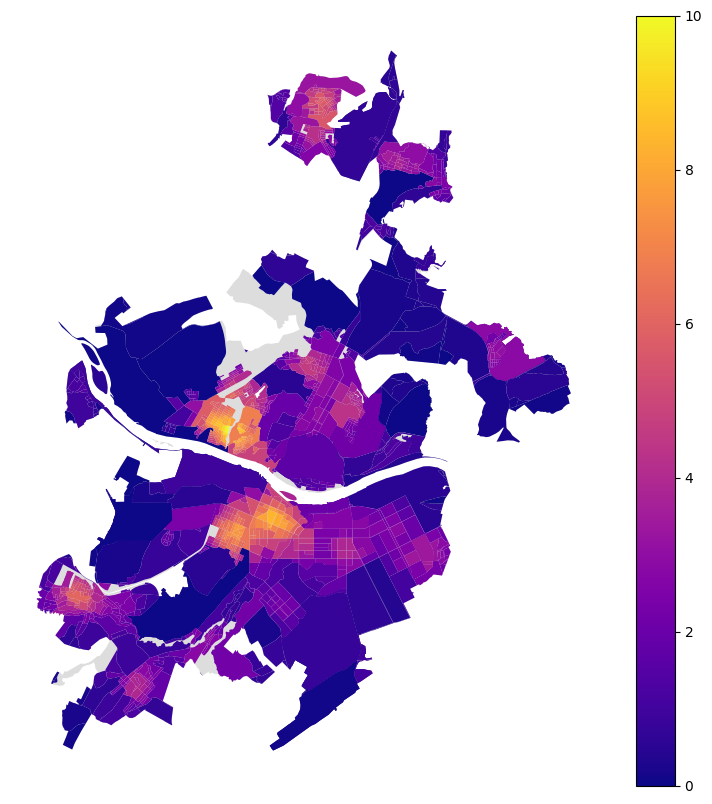

In [ ]:
import matplotlib.pyplot as plt

PLOT_KWARGS = {"column": 'population_centrality', "cmap": "plasma", "vmin": 0, "vmax": 10, "legend": True}
ax = result.plot(color="#ddd", linewidth=0.1, figsize=(10, 10))
result.plot(ax=ax, linewidth=0.1, **PLOT_KWARGS)
ax.axis('off')
plt.savefig('Центральность населения.png', dpi=900, bbox_inches='tight')

In [35]:
blocks_new = pd.merge(blocks, result[['population_centrality']], left_index=True, right_index=True, how='inner')

In [36]:
blocks_new['suffering_blocks']  = min_max_normalization(blocks_new['workers_non_applyed_%']*blocks_new['population_centrality'],0,10)
blocks_new.explore(column='suffering_blocks',cmap='plasma')

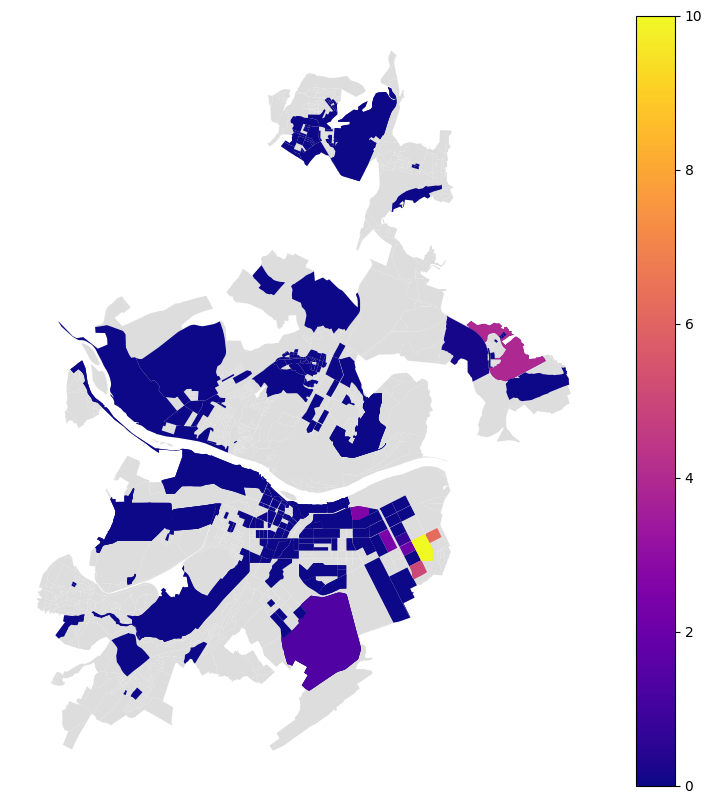

In [ ]:
import matplotlib.pyplot as plt

PLOT_KWARGS = {"column": 'suffering_blocks', "cmap": "plasma", "vmin": 0, "vmax": 10, "legend": True}
ax = blocks_new.plot(color="#ddd", linewidth=0.1, figsize=(10, 10))
blocks_new.plot(ax=ax, linewidth=0.1, **PLOT_KWARGS)
ax.axis('off')
plt.savefig('Страдающие кварталы.png', dpi=900, bbox_inches='tight')

In [38]:
result.head(5)

geometry  population_centrality
id                                                                          
0   POLYGON ((439443.697 6133295.380, 439441.963 6...                   6.35
1   POLYGON ((439217.809 6133376.404, 439247.182 6...                   5.96
2   POLYGON ((439217.809 6133376.404, 439184.460 6...                   6.06
3   POLYGON ((439184.460 6133392.267, 439217.809 6...                   5.77
4   POLYGON ((439184.460 6133392.267, 438928.486 6...                   5.58